In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score , precision_score , roc_curve , precision_recall_curve , auc
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier , GradientBoostingClassifier
from sklearn.preprocessing import MinMaxScaler , StandardScaler
from xgboost.sklearn import XGBClassifier
import lightgbm as lgb
from sklearn.base import clone
from sklearn.model_selection import KFold
import time
import warnings
warnings.filterwarnings("ignore")

### 資料預處理

In [2]:
seed = 10
np.random.seed(seed)
df = pd.read_csv('data.csv')

屬於不平衡數據，所以之後會使用PR-AUC當作判斷模型優劣的指標!!!

負樣本比例 : 75.61%
正樣本比例 : 24.39%


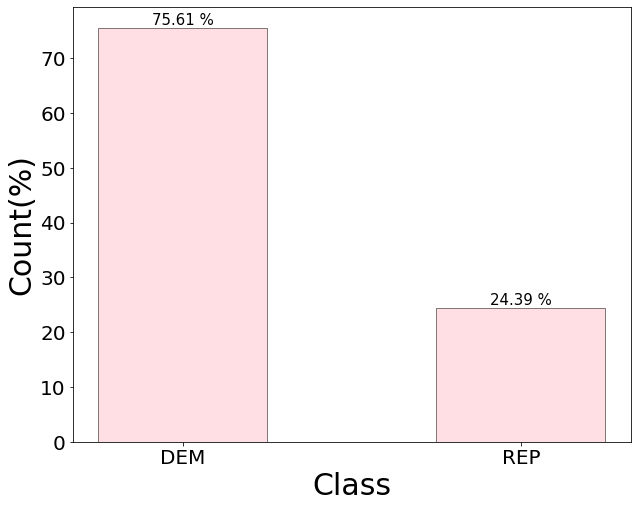

In [3]:
count_classes = df['cand_pty_affiliation'].value_counts()
print('負樣本比例 : {:.2%}'.format(count_classes[0] / count_classes.sum()))
print('正樣本比例 : {:.2%}'.format(count_classes[1] / count_classes.sum()))

count_classes = count_classes / count_classes.sum() * 100 
fig , ax = plt.subplots(1 , 1 , figsize = (10 , 8))
ax.bar(count_classes.index , count_classes.values , alpha = 0.5 , width = 0.5 , facecolor = 'pink' , edgecolor = 'black')
ax.set_xlabel('Class' , fontsize = 30)
ax.set_ylabel('Count(%)' , fontsize = 30)
plt.xticks([0 , 1] , fontsize = 20)
plt.yticks(fontsize = 20)

for a , b in zip(count_classes.index , count_classes.values):  
    plt.text(a , b + 0.005 , '{:.2f} %'.format(b), ha = 'center' , va = 'bottom' , fontsize = 15)

In [4]:
y = (df['cand_pty_affiliation'] == 'REP').astype(np.float32)
X = df.drop(['cand_pty_affiliation'] , axis = 1)
X['cycle'] = X['cycle'].astype(str)

X = pd.get_dummies(X , sparse = True)
x_train , x_test , y_train , y_test =\
train_test_split(X , y , test_size = 0.1 , random_state = seed)
x_train ,  y_train = np.array(x_train) , np.array(y_train)
x_test , y_test = np.array(x_test) , np.array(y_test)

### 將弱分類器預測的結果，直接做平均當作最終預測結果

performance還行!!!

index : 0 , base model : knn , PR-AUC : 0.6847
index : 1 , base model : naive bayes , PR-AUC : 0.6023
index : 2 , base model : random forest , PR-AUC : 0.7150
index : 3 , base model : gbm , PR-AUC : 0.7034
index : 4 , base model : logistic , PR-AUC : 0.6580

Mean_PR-AUC : 0.7261


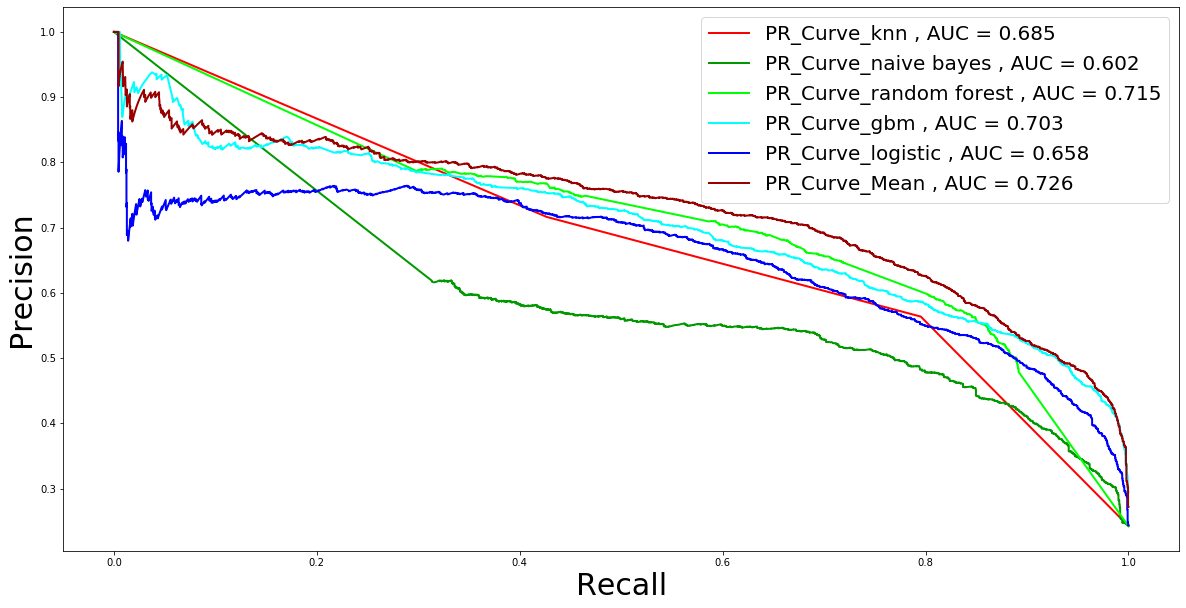

In [5]:
knn = KNeighborsClassifier(n_neighbors = 2)
nb = GaussianNB()
rf = RandomForestClassifier(n_estimators = 3 , max_features = 3 , random_state = seed)
gb = GradientBoostingClassifier(n_estimators = 100 , random_state = seed)
lr = LogisticRegression(C = 50 , random_state = seed)
models = {'knn' : knn ,
          'naive bayes' : nb ,
          'random forest': rf ,
          'gbm': gb ,
          'logistic': lr}

# 將每個弱分類器預測的結果、precision、recall、PR_AUC全部記錄下來，以便後續繪圖
y_prob_set = []
precision_set , recall_set = [] , []
pr_auc_set = []
for i , (model_name , model) in enumerate(zip(models.keys() , models.values())):
    model.fit(x_train , y_train)
    y_prob = model.predict_proba(x_test)[: , 1]

    precision , recall , _ = precision_recall_curve(y_test , y_prob)
    pr_auc = auc(recall , precision)

    print('index : {} , base model : {} , PR-AUC : {:.4f}'.format(i , model_name , pr_auc))
    precision_set.append(precision)
    recall_set.append(recall)
    y_prob_set.append(y_prob)
    pr_auc_set.append(pr_auc)

y_prob_set = np.array(y_prob_set).T
precision_mean , recall_mean , _ = precision_recall_curve(y_test , y_prob_set.mean(axis = 1))
pr_auc_mean = auc(recall_mean , precision_mean)
print('\nMean_PR-AUC : {:.4f}'.format(pr_auc_mean))

colors_set = ['#ff0000' , '#009900' , '#00ff00'  ,
              '#00ffff' , '#0000ff' , '#990000']
fig , ax = plt.subplots(1 , 1 , figsize = (20 , 10))
for i , model_name in enumerate(models.keys()):
    ax.plot(recall_set[i] , precision_set[i] , lw = 2 , color = colors_set[i] ,
            label = 'PR_Curve_{} , AUC = {:.3f}'.format(model_name , pr_auc_set[i]))

ax.plot(recall_mean , precision_mean , lw = 2 , color = colors_set[-1] ,
        label = 'PR_Curve_{} , AUC = {:.3f}'.format('Mean' , pr_auc_mean))
ax.set_xlabel('Recall' , fontsize = 30)
ax.set_ylabel('Precision' , fontsize = 30)
ax.legend(loc = 'best' , fontsize = 20)

### 根據訓練集資料，每個弱分類器所產生的PA_AUC當作權重，做加權平均當作預測結果

performance略微提升!!!

index : 0 , base model : knn , PR-AUC : 0.6847
index : 1 , base model : naive bayes , PR-AUC : 0.6023
index : 2 , base model : random forest , PR-AUC : 0.7150
index : 3 , base model : gbm , PR-AUC : 0.7034
index : 4 , base model : logistic , PR-AUC : 0.6580
index : 0 , base model : knn , Traing_PR-AUC : 0.8592
index : 1 , base model : naive bayes , Traing_PR-AUC : 0.6026
index : 2 , base model : random forest , Traing_PR-AUC : 0.9199
index : 3 , base model : gbm , Traing_PR-AUC : 0.6954
index : 4 , base model : logistic , Traing_PR-AUC : 0.6624

Weighted Sum_PR-AUC : 0.7338


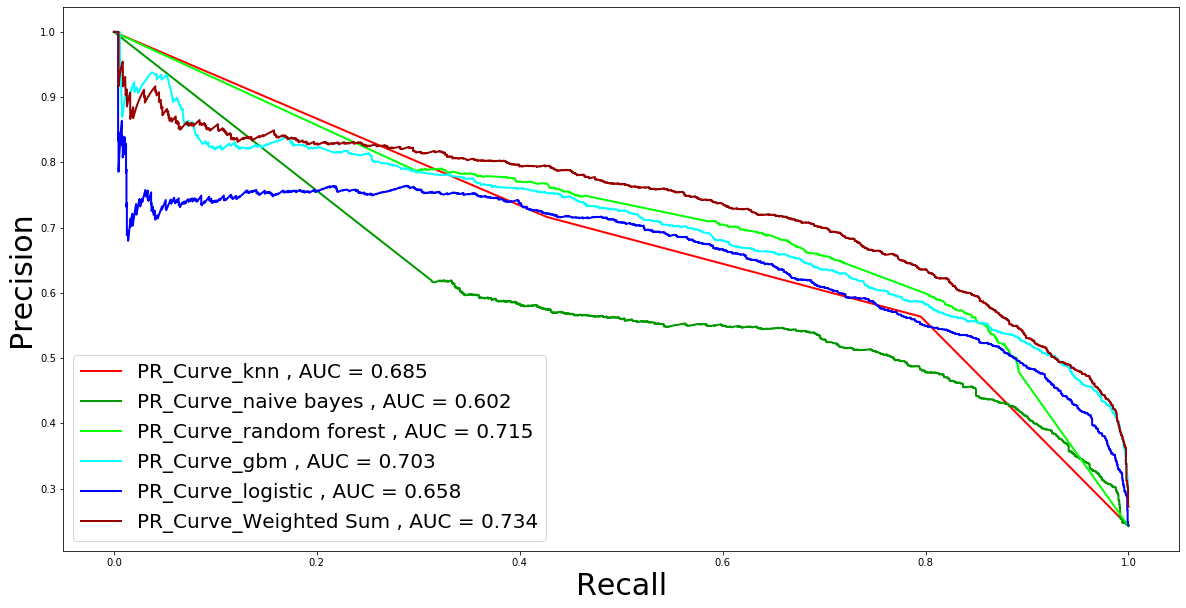

In [6]:
knn = KNeighborsClassifier(n_neighbors = 2)
nb = GaussianNB()
rf = RandomForestClassifier(n_estimators = 3 , max_features = 3 , random_state = seed)
gb = GradientBoostingClassifier(n_estimators = 100 , random_state = seed)
lr = LogisticRegression(C = 50 , random_state = seed)
models = {'knn' : knn ,
          'naive bayes' : nb ,
          'random forest': rf ,
          'gbm': gb ,
          'logistic': lr}

# 將每個弱分類器預測的結果、precision、recall、PR_AUC全部記錄下來，以便後續繪圖
y_prob_set = []
precision_set , recall_set = [] , []
pr_auc_set = []
for i , (model_name , model) in enumerate(zip(models.keys() , models.values())):
    model.fit(x_train , y_train)
    y_prob = model.predict_proba(x_test)[: , 1]

    precision , recall , _ = precision_recall_curve(y_test , y_prob)
    pr_auc = auc(recall , precision)

    print('index : {} , base model : {} , PR-AUC : {:.4f}'.format(i , model_name , pr_auc))    
    precision_set.append(precision)
    recall_set.append(recall)
    y_prob_set.append(y_prob)
    pr_auc_set.append(pr_auc)
y_prob_set = np.array(y_prob_set).T

# 根據x_train，得到每一個弱分類器的PR-AUC，再用PR-AUC當作弱分類器所佔的權重
model_weight = []
for i , (model_name , model) in enumerate(zip(models.keys() , models.values())):
    y_prob_train = model.predict_proba(x_train)[: , 1]

    precision , recall , _ = precision_recall_curve(y_train , y_prob_train)
    pr_auc_train = auc(recall , precision)

    print('index : {} , base model : {} , Traing_PR-AUC : {:.4f}'.format(i , model_name , pr_auc_train))
    model_weight.append(pr_auc_train)
model_weight = np.array(model_weight)
model_weight = model_weight / model_weight.sum()
model_weight = np.reshape(model_weight , [5 , 1])

# 對每個弱分類器的預測結果作加權平均，當作最終預測結果
y_prob_weighted_sum = np.matmul(y_prob_set , model_weight)
precision_weighted_sum , recall_weighted_sum , _ = precision_recall_curve(y_test , y_prob_weighted_sum)
pr_auc_weighted_sum= auc(recall_weighted_sum , precision_weighted_sum)
print('\nWeighted Sum_PR-AUC : {:.4f}'.format(pr_auc_weighted_sum))

colors_set = ['#ff0000' , '#009900' , '#00ff00'  ,
              '#00ffff' , '#0000ff' , '#990000']
fig , ax = plt.subplots(1 , 1 , figsize = (20 , 10))
for i , model_name in enumerate(models.keys()):
    ax.plot(recall_set[i] , precision_set[i] , lw = 2 , color = colors_set[i] ,
            label = 'PR_Curve_{} , AUC = {:.3f}'.format(model_name , pr_auc_set[i]))

ax.plot(recall_weighted_sum , precision_weighted_sum , lw = 2 , color = colors_set[-1] ,
        label = 'PR_Curve_{} , AUC = {:.3f}'.format('Weighted Sum' , pr_auc_weighted_sum))
ax.set_xlabel('Recall' , fontsize = 30)
ax.set_ylabel('Precision' , fontsize = 30)
ax.legend(loc = 'best' , fontsize = 20)

### 重頭戲!!!!
### 前面我們都直接決定每個弱分類器的權重，但現在使用Stacking，讓機器自己做決定!!!!

performance又提升了!!!

Stacking first , index : 0 , base learner : knn
Stacking first , index : 1 , base learner : naive bayes
Stacking first , index : 2 , base learner : random forest
Stacking first , index : 3 , base learner : gbm
Stacking first , index : 4 , base learner : logistic
Stacking second , index : 0 , base learner : knn
Stacking second , index : 1 , base learner : naive bayes
Stacking second , index : 2 , base learner : random forest
Stacking second , index : 3 , base learner : gbm
Stacking second , index : 4 , base learner : logistic

Stacking_PR-AUC : 0.7457


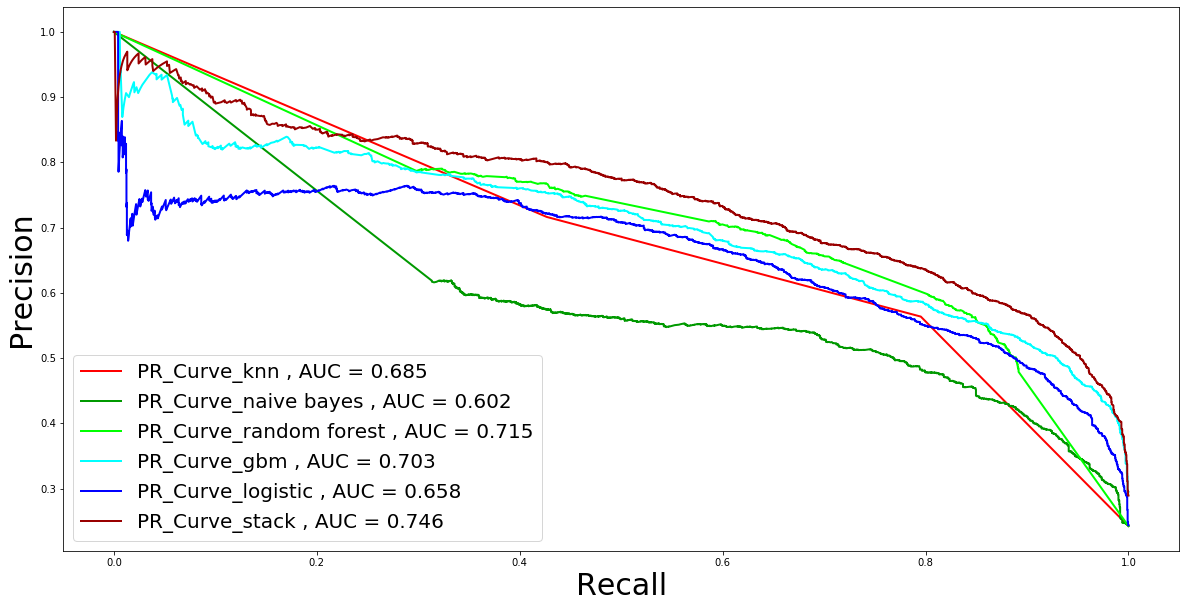

In [7]:
# 這裡開始使用Stacking的技巧    
knn = KNeighborsClassifier(n_neighbors = 2)
nb = GaussianNB()
rf = RandomForestClassifier(n_estimators = 3 , max_features = 3 , random_state = seed)
gb = GradientBoostingClassifier(n_estimators = 100 , random_state = seed)
lr = LogisticRegression(C = 50 , random_state = seed)
learners = {'knn' : knn ,
            'naive bayes' : nb ,
            'random forest': rf ,
            'gbm': gb ,
            'logistic': lr}

x_train_base , x_prob_base , y_train_base , y_prob_base =\
train_test_split(x_train , y_train , test_size = 0.5 , random_state = seed)

# Step1 
# 利用x_prob_base與y_train_base訓練弱分類器
# 接著收集弱分類器針對x_test_fold的預測結果，存進y_prob_first當作second_learner的訓練資料
y_prob_first = []
for i , (learner_name , learner) in enumerate(zip(learners.keys() , learners.values())):
    print('Stacking first , index : {} , base learner : {}'.format(i , learner_name))
    learner.fit(x_train_base , y_train_base)
    y_prob = learner.predict_proba(x_prob_base)[: , 1]
    y_prob_first.append(y_prob)
y_prob_first = np.array(y_prob_first).T

# Step2 ⇨ 利用y_prob_first與y_prob_base開始訓練second_learner
second_learner = lgb.LGBMClassifier(num_leaves = 200 ,
                                    learning_rate = 0.005 ,
                                    n_estimators = 2000 ,
                                    max_depth = 4 ,
                                    random_state = seed ,
                                    n_job = -1)
second_learner.fit(y_prob_first , y_prob_base)

# Step3 ⇨ 將x_test丟入弱分類器中產生初步預測結果
y_prob_second = []
for i , (learner_name , learner) in enumerate(zip(learners.keys() , learners.values())):
    print('Stacking second , index : {} , base learner : {}'.format(i , learner_name))
    y_prob = learner.predict_proba(x_test)[: , 1]
    y_prob_second.append(y_prob)
y_prob_second = np.array(y_prob_second).T

# Step4 ⇨ 再將弱分類器產生初步預測結果丟進second_learner中得到最終預測結果
y_prob_final = second_learner.predict_proba(y_prob_second)[: , 1]


# 接下來開始繪圖
knn = KNeighborsClassifier(n_neighbors = 2)
nb = GaussianNB()
rf = RandomForestClassifier(n_estimators = 3 , max_features = 3 , random_state = seed)
gb = GradientBoostingClassifier(n_estimators = 100 , random_state = seed)
lr = LogisticRegression(C = 50 , random_state = seed)
models = {'knn' : knn ,
          'naive bayes' : nb ,
          'random forest': rf ,
          'gbm': gb ,
          'logistic': lr}

# 將每個弱分類器的precision、recall、PR_AUC全部記錄下來，以便後續繪圖
precision_set , recall_set = [] , []
pr_auc_set = []
for i , (model_name , model) in enumerate(zip(models.keys() , models.values())):
    model.fit(x_train , y_train)
    y_prob = model.predict_proba(x_test)[: , 1]

    precision , recall , _ = precision_recall_curve(y_test , y_prob)
    pr_auc = auc(recall , precision)
    precision_set.append(precision)
    recall_set.append(recall)
    pr_auc_set.append(pr_auc)

fig , ax = plt.subplots(1 , 1 , figsize = (20 , 10))
colors_set = ['#ff0000' , '#009900' , '#00ff00'  ,
              '#00ffff' , '#0000ff' , '#990000']
for i , model_name in enumerate(models.keys()):
    ax.plot(recall_set[i] , precision_set[i] , lw = 2 , color = colors_set[i] ,
            label = 'PR_Curve_{} , AUC = {:.3f}'.format(model_name , pr_auc_set[i]))

precision_stack , recall_stack, _ = precision_recall_curve(y_test , y_prob_final)
pr_auc_stack = auc(recall_stack , precision_stack)
print('\nStacking_PR-AUC : {:.4f}'.format(pr_auc_stack))

ax.plot(recall_stack , precision_stack , lw = 2 , color = colors_set[-1] ,
        label = 'PR_Curve_{} , AUC = {:.3f}'.format('stack' , pr_auc_stack))
ax.set_xlabel('Recall' , fontsize = 30)
ax.set_ylabel('Precision' , fontsize = 30)
ax.legend(loc = 'best' , fontsize = 20)

### 感覺在訓練兩階段的模型都沒用到全部數據，這部分可以用交叉驗證(CV)解決!!!

最後performance又再次提升了!!!<br>
但這個方法在Step2中非常耗時，因此另外寫一支程式Stacking_CV_multiprocessing.py，用多進程的方式增快速度，整體速度為原來的2倍!!

index : 0 , base learner : knn
index : 1 , base learner : naive bayes
index : 2 , base learner : random forest
index : 3 , base learner : gbm
index : 4 , base learner : logistic
Stacking first , outer_loop : 0 , inner_loop : 0 , base learner : knn
Stacking first , outer_loop : 0 , inner_loop : 1 , base learner : naive bayes
Stacking first , outer_loop : 0 , inner_loop : 2 , base learner : random forest
Stacking first , outer_loop : 0 , inner_loop : 3 , base learner : gbm
Stacking first , outer_loop : 0 , inner_loop : 4 , base learner : logistic
Stacking first , outer_loop : 1 , inner_loop : 0 , base learner : knn
Stacking first , outer_loop : 1 , inner_loop : 1 , base learner : naive bayes
Stacking first , outer_loop : 1 , inner_loop : 2 , base learner : random forest
Stacking first , outer_loop : 1 , inner_loop : 3 , base learner : gbm
Stacking first , outer_loop : 1 , inner_loop : 4 , base learner : logistic
Stacking first , outer_loop : 2 , inner_loop : 0 , base learner : knn
Stacki

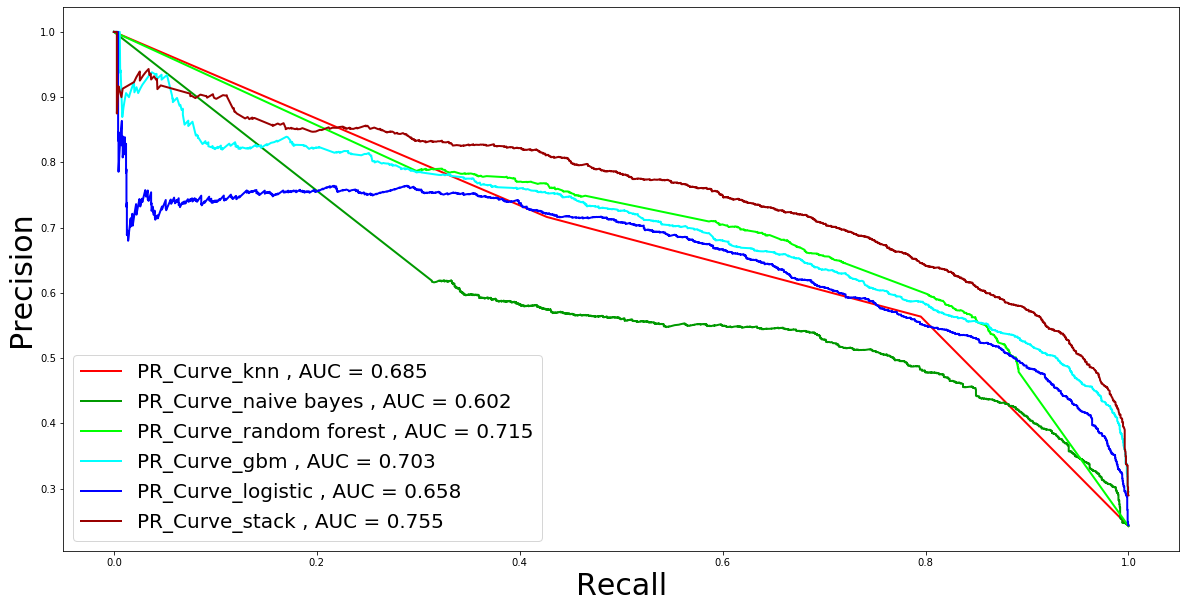

In [8]:
knn = KNeighborsClassifier(n_neighbors = 2)
nb = GaussianNB()
rf = RandomForestClassifier(n_estimators = 3 , max_features = 3 , random_state = seed)
gb = GradientBoostingClassifier(n_estimators = 100 , random_state = seed)
lr = LogisticRegression(C = 50 , random_state = seed)
learners = {'knn' : knn ,
            'naive bayes' : nb ,
            'random forest': rf ,
            'gbm': gb ,
            'logistic': lr}

start = time.time()
# Step1 ⇨ 針對x_train與y_train，先訓練一次弱分類器
for i , (learner_name , learner) in enumerate(zip(learners.keys() , learners.values())):
    print('index : {} , base learner : {}'.format(i , learner_name))
    learner.fit(x_train , y_train)

# Step2
y_prob_cv , y_test_cv = [] , []
for i , (train_idx , test_idx) in enumerate(KFold(4).split(x_train)):
    x_train_fold , y_train_fold = x_train[train_idx , :] , y_train[train_idx]
    x_test_fold , y_test_fold = x_train[test_idx] , y_train[test_idx]

    fold_learners = {learner_name : clone(learner) for learner_name , learner in learners.items()}

    # 利用x_train_fold與y_train_fold再訓練每個弱分類器
    # 接著收集各個分類器針對x_test_fold的預測結果，並存進y_prob_first
    y_prob_first = []
    for j , (learner_name , learner) in enumerate(zip(fold_learners.keys() , fold_learners.values())):
        print('Stacking first , outer_loop : {} , inner_loop : {} , base learner : {}'.format(i , j , learner_name))
        learner.fit(x_train_fold , y_train_fold)
        y_prob = learner.predict_proba(x_test_fold)[: , 1]
        y_prob_first.append(y_prob)
    y_prob_first = np.array(y_prob_first).T
    y_prob_cv.append(y_prob_first)    
    y_test_cv.append(y_test_fold)

y_prob_cv = np.vstack(y_prob_cv)
y_test_cv = np.hstack(y_test_cv)

# Step3 ⇨ 利用y_prob_cv與y_test_cv開始訓練second_learner
second_learner = lgb.LGBMClassifier(num_leaves = 200 ,
                                    learning_rate = 0.005 ,
                                    n_estimators = 1000 ,
                                    max_depth = 4 ,
                                    random_state = seed ,
                                    n_job = -1)
second_learner.fit(y_prob_cv , y_test_cv)

# Step4 ⇨ 將x_test丟入弱分類器中產生初步預測結果
y_prob_second = []
for i , (learner_name , learner) in enumerate(zip(learners.keys() , learners.values())):
    print('Stacking second , index : {} , base learner : {}'.format(i , learner_name))
    y_prob = learner.predict_proba(x_test)[: , 1]
    y_prob_second.append(y_prob)
y_prob_second = np.array(y_prob_second).T

# Step5 ⇨ 再將弱分類器產生初步預測結果丟進second_learner中得到最終預測結果
y_prob_final = second_learner.predict_proba(y_prob_second)[: , 1]

precision_stack , recall_stack , _ = precision_recall_curve(y_test , y_prob_final)
pr_auc_stack = auc(recall_stack , precision_stack)
print('\nStacking_PR-AUC : {:.4f}'.format(pr_auc_stack))

end = time.time()
print('Operation Time : {}'.format(end - start))

# 接下來開始繪圖
knn = KNeighborsClassifier(n_neighbors = 2)
nb = GaussianNB()
rf = RandomForestClassifier(n_estimators = 3 , max_features = 3 , random_state = seed)
gb = GradientBoostingClassifier(n_estimators = 100 , random_state = seed)
lr = LogisticRegression(C = 50 , random_state = seed)
models = {'knn' : knn ,
          'naive bayes' : nb ,
          'random forest': rf ,
          'gbm': gb ,
          'logistic': lr}

# 將每個弱分類器的precision、recall、PR_AUC全部記錄下來，以便後續繪圖
precision_set , recall_set = [] , []
pr_auc_set = []
for i , (model_name , model) in enumerate(zip(models.keys() , models.values())):
    model.fit(x_train , y_train)
    y_prob = model.predict_proba(x_test)[: , 1]

    precision , recall , _ = precision_recall_curve(y_test , y_prob)
    pr_auc = auc(recall , precision)
    precision_set.append(precision)
    recall_set.append(recall)
    pr_auc_set.append(pr_auc)

fig , ax = plt.subplots(1 , 1 , figsize = (20 , 10))
colors_set = ['#ff0000' , '#009900' , '#00ff00'  ,
              '#00ffff' , '#0000ff' , '#990000']
for i , model_name in enumerate(models.keys()):
    ax.plot(recall_set[i] , precision_set[i] , lw = 2 , color = colors_set[i] ,
            label = 'PR_Curve_{} , AUC = {:.3f}'.format(model_name , pr_auc_set[i]))

ax.plot(recall_stack , precision_stack , lw = 2 , color = colors_set[-1] ,
        label = 'PR_Curve_{} , AUC = {:.3f}'.format('stack' , pr_auc_stack))
ax.set_xlabel('Recall' , fontsize = 30)
ax.set_ylabel('Precision' , fontsize = 30)
ax.legend(loc = 'best' , fontsize = 20)